In this notebook I will investigate the characteristic with which it is possible to have a higher response for an amplitude modulated signal. Is it resonance alone?

In [1]:
import functions as fn
import numpy as np
import matplotlib.pyplot as plt

In [112]:
Sim_period = 50  # seconds
Sim_fs = 100000  # samples per second

Sim_dt = 1/Sim_fs
Sim_t = np.arange(0, Sim_period, Sim_dt)

In [113]:
C = .00001  # F
L = 25  # H
R_L = 200  # Ohm  # 200
g_L = 1/R_L  # S

I_stim = 1e-6

tau_L = L / R_L

print('Inductor time constant:', tau_L, 's')
print('Resonance frequency:', 1/(2*np.pi*np.sqrt(L*C)), 'Hz')

Inductor time constant: 0.125 s
Resonance frequency: 10.065842420897408 Hz


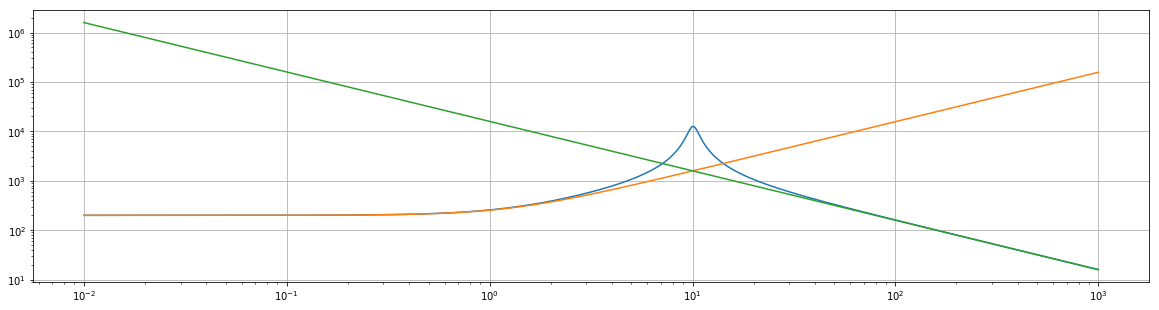

In [114]:
f = np.arange(0.01,1000,.01)  # Hz
w = 2 * np.pi * f

z = (1j*w*C + 1/(1j*w*L + R_L)) ** -1
z_amp = np.sqrt(z.real**2 + z.imag**2)

z_L = 1j*w*L + R_L
z_L_amp = np.sqrt(z_L.real**2 + z_L.imag**2)

z_C = (1j * w * C) ** -1
z_C_amp = np.sqrt(z_C.real**2 + z_C.imag**2)

plt.figure(figsize=(20,5))
plt.loglog(f, z_amp)
plt.loglog(f, z_L_amp)
plt.loglog(f, z_C_amp)
plt.grid()
plt.show()

In [115]:
I = I_stim * np.ones(Sim_t.shape)  # pA
# Sim_t = Sim_t[:Sim_fs*1]
# slope
slope = fn.gen_slope(init_time=0,
                   end_time= 5,
                   time_points=Sim_t)


I1 = fn.gen_sin(init_time=0,
                freq=1,
                phase=0,
                time_points=Sim_t)
I2 = fn.gen_sin(init_time=0,
                freq=1000,
                phase=0,
                time_points=Sim_t)
I3, freq = fn.gen_chirp(Chirp_init_freq=1, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=20, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

I = slope * (I_stim * (I3 * .1 + I2 * 1) + 0)
I = np.abs(I)

# I3 = fn.gen_pulse(init_time=1,
#                   on_width=47,
#                   off_width=1,
#                   time_points=Sim_t)

# # Chirp stimulation
out, freq = fn.gen_chirp(Chirp_init_freq=0.1, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=20, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

# I      = slope * I_stim * out # pA
# I = np.abs(I)

In [116]:
Vm = np.zeros(Sim_t.shape)
I_L = np.zeros(Sim_t.shape)
nl = np.zeros(Vm.shape)

In [117]:
for i in range(I.shape[0]-1):
    
    # current through the inductor
    I_L_ss = Vm[i] * g_L
    dILdt = (I_L_ss - I_L[i]) / tau_L
    I_L[i+1] = I_L[i] + dILdt * Sim_dt
    
    dVmdt = (I[i] - I_L[i]) / C
    Vm[i+1] = Vm[i] + dVmdt * Sim_dt

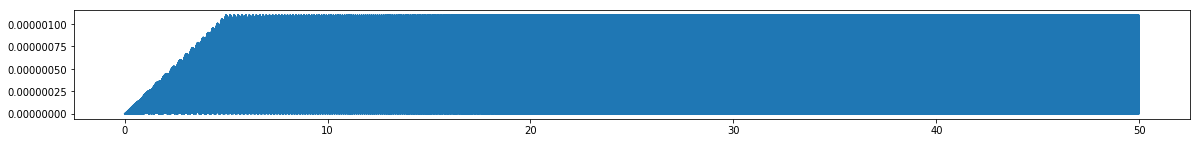

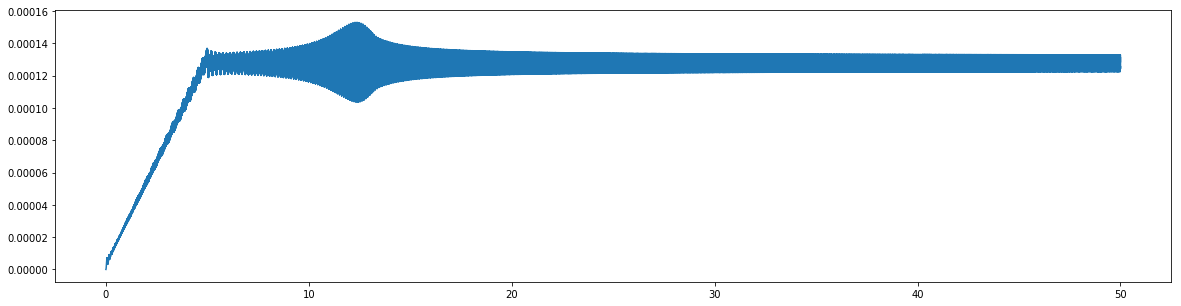

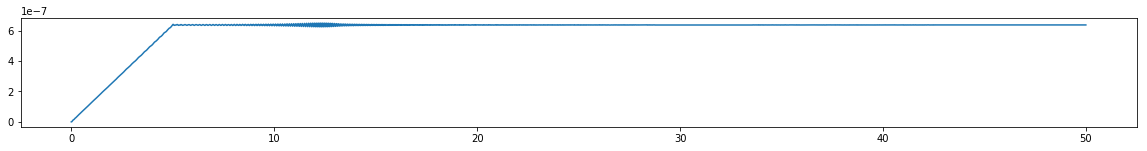

In [118]:
plt.figure(figsize=(20,2))
plt.plot(Sim_t, I)
plt.show()

plt.figure(figsize=(20,5))
plt.plot(Sim_t, Vm)
plt.show()

plt.figure(figsize=(20,2))
plt.plot(Sim_t, I_L)
plt.show()

## Resonance is not enough

So i think it is pretty clear why the neuron might be firing. We know that the stimulaitng signal only has the high frequency components. however, the membrane is acting like an integrator as well as a resonator. hence after passing by the neuron membrane another frequency componenent (which is at least close the resonance frequency of the neuron) is added to the signal. So what I am planning to do:

1. Create a diode demosuator ciruit
    - Have the diode dependent on stimulation current and capacitor voltage
2. Implement the diode (which depends on capacitor potential) as Na and Potassium currents
3. Add the inductor branch and let the circuit integrates and resonates

### Circuit I

In [119]:
C = .00001  # F
R_leak = 1000  # Ohm  # 200
g_leak = 1/R_leak  # S

I_stim = 1e-6

print('integration time constant is', (C*R_leak), 'seconds')

integration time constant is 0.01 seconds


In [151]:
slope = fn.gen_slope(init_time=0,
                   end_time= .5,
                   time_points=Sim_t)
# pulse
I3 = fn.gen_pulse(init_time=1,
                  on_width=1,
                  off_width=1,
                  time_points=Sim_t)
I = I3


I1 = fn.gen_sin(init_time=0,
                freq=1010,
                phase=0,
                time_points=Sim_t)
I2 = fn.gen_sin(init_time=0,
                freq=1000,
                phase=0,
                time_points=Sim_t)
I3, freq = fn.gen_chirp(Chirp_init_freq=1, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=20, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

I = slope * (I_stim * (I3 * .1 + I2 * 1) + 0)
I = slope * (I_stim * (I1 + I2))
# I = np.abs(I)

# Chirp stimulation
out, freq = fn.gen_chirp(Chirp_init_freq=0.1, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=20, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

# I      = slope * I_stim * out # pA
# I = np.abs(I)

In [152]:
Vm = np.zeros(Sim_t.shape)
I_L = np.zeros(Sim_t.shape)
nl = np.zeros(Vm.shape)

In [153]:
for i in range(I.shape[0]-1):
    
    # adding the diode (function of I_stim)
    I[i] = np.maximum(0, I[i])
    
    # current through the leak branch
    I_leak = g_leak * Vm[i]
    
    
    dVmdt = (I[i] - I_leak) / C
    Vm[i+1] = Vm[i] + dVmdt * Sim_dt

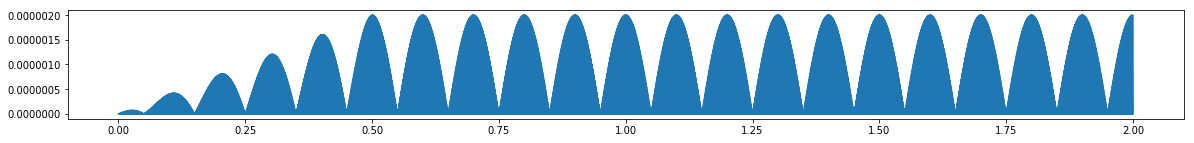

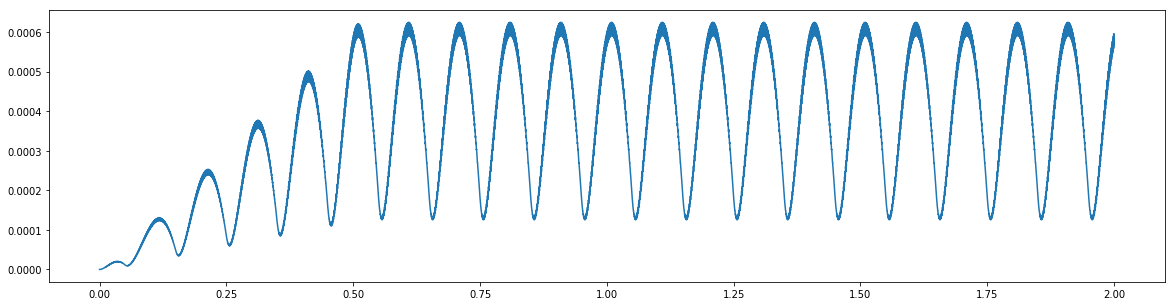

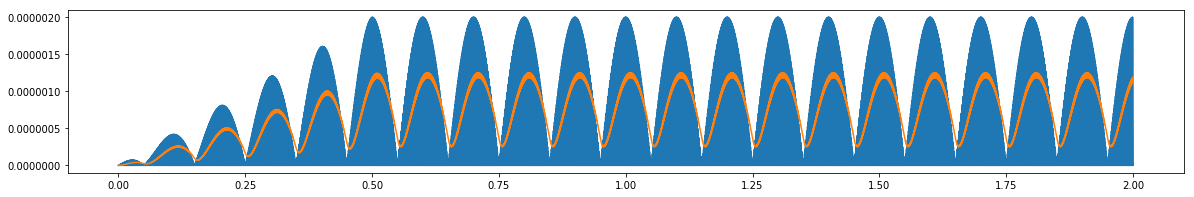

In [154]:
plt.figure(figsize=(20,2))
plt.plot(Sim_t[:200000], I[:200000])
plt.show()

plt.figure(figsize=(20,5))
plt.plot(Sim_t[:200000], Vm[:200000])
plt.show()

plt.figure(figsize=(20,3))
plt.plot(Sim_t[:200000], I[:200000])
plt.plot(Sim_t[:200000], Vm[:200000]/500)
plt.show()

Note that the faster the time constant (higher), the better the integration. At some point i would like to express this RC branch as a dynamic variable (it might be helpful)

### Circuit II

In this circuit we are gonna do the same thing (rectification of the input current); however, this time, the rectification is gonna be a function of membrane voltage and not the input current.

In [155]:
slope = fn.gen_slope(init_time=0,
                   end_time= .5,
                   time_points=Sim_t)
# pulse
I3 = fn.gen_pulse(init_time=1,
                  on_width=1,
                  off_width=1,
                  time_points=Sim_t)
I = I3


I1 = fn.gen_sin(init_time=0,
                freq=1010,
                phase=0,
                time_points=Sim_t)
I2 = fn.gen_sin(init_time=0,
                freq=1000,
                phase=0,
                time_points=Sim_t)
I3, freq = fn.gen_chirp(Chirp_init_freq=1, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=20, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

I = slope * (I_stim * (I3 * .1 + I2 * 1) + 0)
I = slope * (I_stim * (I1 + I2))
# I = np.abs(I)

# Chirp stimulation
out, freq = fn.gen_chirp(Chirp_init_freq=0.1, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=20, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

# I      = slope * I_stim * out # pA
# I = np.abs(I)

In [156]:
Vm = np.zeros(Sim_t.shape)
I_L = np.zeros(Sim_t.shape)
nl = np.zeros(Sim_t.shape)

In [157]:
for i in range(I.shape[0]-1):
    
    # adding the diode (function of I_stim)
#     if I[i] <= 0:
#         I[i] = 0
    
    # current through the leak branch
    I_leak = g_leak * Vm[i]
    
    
    dVmdt = (I[i] - I_leak) / C
    Vm[i+1] = Vm[i] + dVmdt * Sim_dt

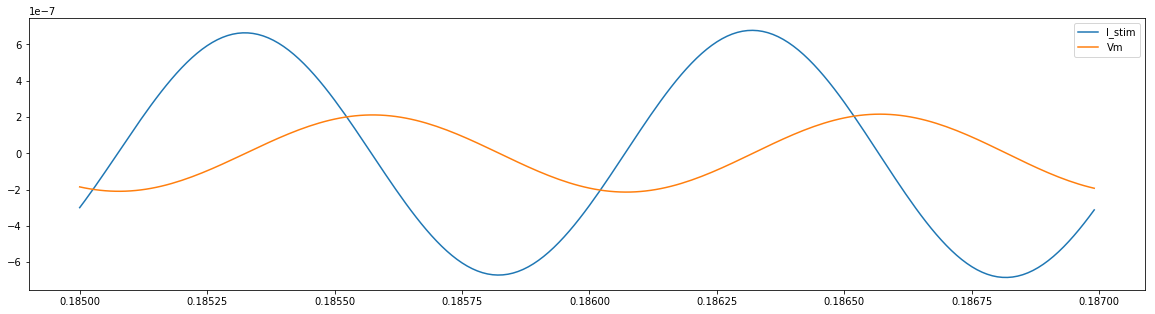

In [158]:
fs = 18500
fe = 18700
plt.figure(figsize=(20,5))
plt.plot(Sim_t[fs:fe], I[fs:fe], label='I_stim')
plt.plot(Sim_t[fs:fe], Vm[fs:fe]/50,  label='Vm')
plt.legend()
plt.show()

As we can see above, the ideea of having the diode as a function of Vm and then act on I_stim is not a good idea, beacuse Vm is lagging the current with 90 degrees (this is what's gonna happen in high frequency btw!).<br/>
So if we want to make it dependent on Vm, then we need to compensate for this phase shift. that means if the membrane potential (Vm) is less than zero now, then make the current in the current at 270 degrees 0. Let's do some calculation:<br/>
the frequency is *freq*. the period for one cycle is *1/freq*. number of samples in one cycle is *Sim_fs/freq*. and we want to influence a sample 270 degrees away, that is three quarter of a cycle (and samples in a cycle), so given that the current index is i, we want to influence the *i + .75 x Sim_fs/freq* sample. let's do it

In [159]:
for i in range(I.shape[0]-1):
    
    # adding the diode (function of I_stim)
    I_ind = int(i + .75 * Sim_fs/1005)
    if Vm[i] < 0 and I_ind < I.shape[0]:
        I[I_ind] = 0
    
    # current through the leak branch
    I_leak = g_leak * Vm[i]
    
    
    dVmdt = (I[i] - I_leak) / C
    Vm[i+1] = Vm[i] + dVmdt * Sim_dt

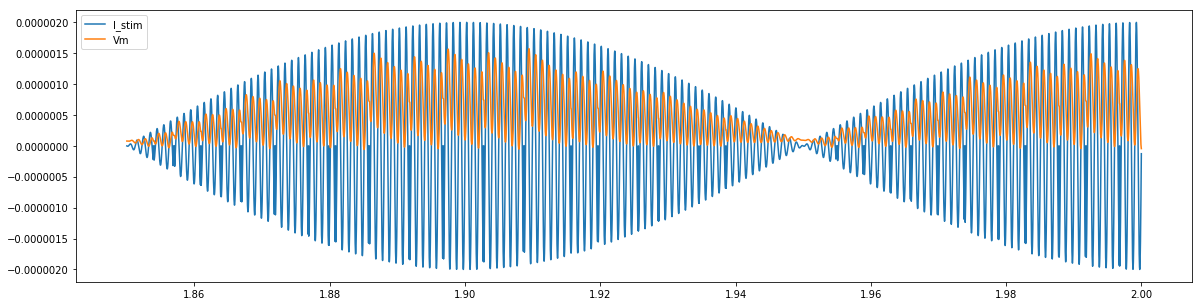

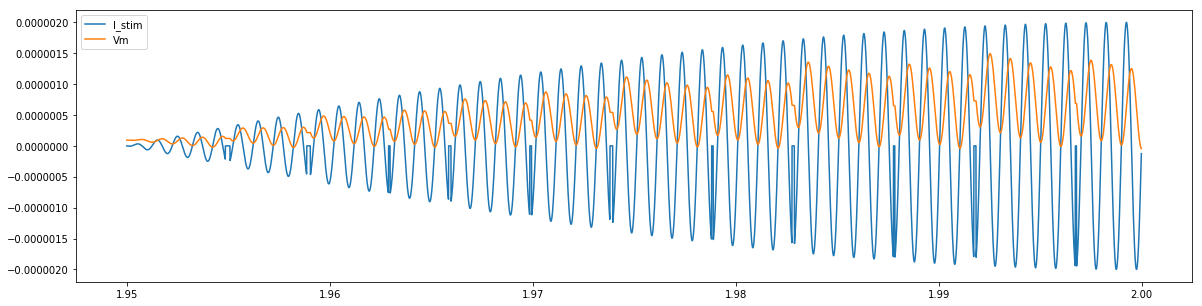

In [163]:
fs = 185000
fe = 200000
plt.figure(figsize=(20,5))
plt.plot(Sim_t[fs:fe], I[fs:fe], label='I_stim')
plt.plot(Sim_t[fs:fe], Vm[fs:fe]/50,  label='Vm')
plt.legend()
plt.show()

fs = 195000
fe = 200000
plt.figure(figsize=(20,5))
plt.plot(Sim_t[fs:fe], I[fs:fe], label='I_stim')
plt.plot(Sim_t[fs:fe], Vm[fs:fe]/50,  label='Vm')
plt.legend()
plt.show()

## Time constants and integration

In [199]:
# pulse
I3 = fn.gen_pulse(init_time=1,
                  on_width=1,
                  off_width=1,
                  time_points=Sim_t)
I = I3


I1 = fn.gen_sin(init_time=0,
                freq=1000,
                phase=0,
                time_points=Sim_t)

I = I1

In [288]:
# signal frequency is 1000, hence the time constant must be 5 * .001
tau = .001 * 5
cs = np.zeros(Sim_t.shape)

In [203]:
for i in range(I.shape[0]-1):  
    
    dsdt = (I[i] - cs[i]) / tau
    cs[i+1] = cs[i] + dsdt * Sim_dt

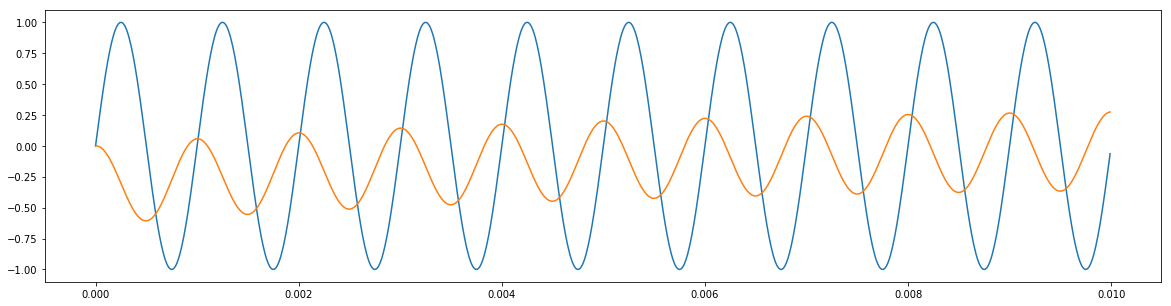

In [205]:
fs = 0
fe = 1000
plt.figure(figsize=(20,5))
plt.plot(Sim_t[fs:fe], I[fs:fe])
plt.plot(Sim_t[fs:fe], -10*cs[fs:fe])
plt.show()

As we increase the time constants, it takes more time to integrate, as a result the lag is increases. it seems that the time constant for the dynamic must be 5 times the reciprocal os the signal freuqency

## Circuit with nonlinearity with time constant

In this circuit, the nonlinearity is a function of Vm which has a time constant, and it effects the current

In [284]:
slope = fn.gen_slope(init_time=0,
                   end_time= .5,
                   time_points=Sim_t)
# pulse
I3 = fn.gen_pulse(init_time=1,
                  on_width=1,
                  off_width=1,
                  time_points=Sim_t)
I = I3


I1 = fn.gen_sin(init_time=0,
                freq=1010,
                phase=0,
                time_points=Sim_t)
I2 = fn.gen_sin(init_time=0,
                freq=1000,
                phase=0,
                time_points=Sim_t)
I3, freq = fn.gen_chirp(Chirp_init_freq=1, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=20, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

I = slope * (I_stim * (I3 * .1 + I2 * 1) + 0)
I = slope * (I_stim * (I1 + I2))
# I = np.abs(I)

# Chirp stimulation
out, freq = fn.gen_chirp(Chirp_init_freq=0.1, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=20, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

# I      = slope * I_stim * out # pA
# I = np.abs(I)

In [285]:
# signal frequency is 1000, hence the time constant must be 5 * .001
tau = .001 * 5
cs = np.zeros(Sim_t.shape)

Vm = np.zeros(Sim_t.shape)
I_L = np.zeros(Sim_t.shape)
nl = np.zeros(Sim_t.shape)

In [291]:
for i in range(I.shape[0]-1):
    
    # adding the nonlinearity
    dsdt = (-Vm[i] - cs[i]) / tau
    cs[i+1] = cs[i] + dsdt * Sim_dt
    
    if cs[i] > 0:
        I[i] = I[i] * 2
    
    # current through the leak branch
    I_leak = g_leak * Vm[i]
    
    
    dVmdt = (I[i] - I_leak) / C
    Vm[i+1] = Vm[i] + dVmdt * Sim_dt

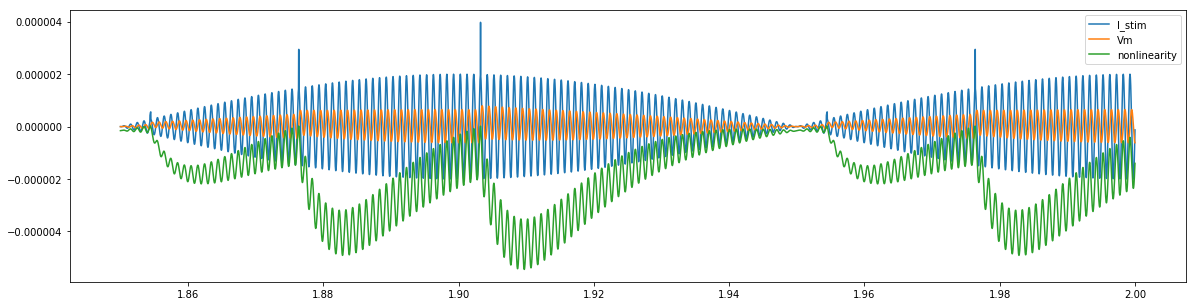

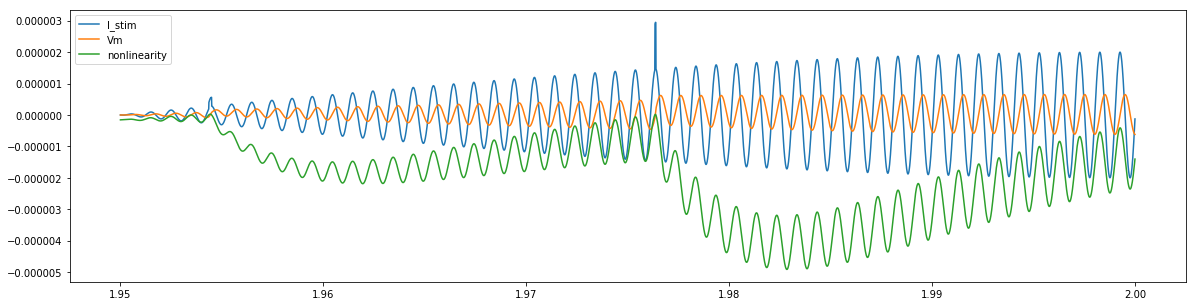

In [292]:
fs = 185000
fe = 200000
plt.figure(figsize=(20,5))
plt.plot(Sim_t[fs:fe], I[fs:fe], label='I_stim')
plt.plot(Sim_t[fs:fe], Vm[fs:fe]/50,  label='Vm')
plt.plot(Sim_t[fs:fe], cs[fs:fe],  label='nonlinearity')
plt.legend()
plt.show()

fs = 195000
fe = 200000
plt.figure(figsize=(20,5))
plt.plot(Sim_t[fs:fe], I[fs:fe], label='I_stim')
plt.plot(Sim_t[fs:fe], Vm[fs:fe]/50,  label='Vm')
plt.plot(Sim_t[fs:fe], cs[fs:fe],  label='nonlinearity')
plt.legend()
plt.show()